In [1]:
# imports

import requests
import pandas as pd
import json
import html
import os.path
import numpy as np
from scipy import stats

In [2]:

p5 = ["SEC","Pac-12","FBS Independents","Big 12", "ACC", "Big Ten"]
g5 = ["Mountain West", "Mid-American","Sun Belt","Conference USA","American Athletic"]
fbs = p5 + g5
fbs

['SEC',
 'Pac-12',
 'FBS Independents',
 'Big 12',
 'ACC',
 'Big Ten',
 'Mountain West',
 'Mid-American',
 'Sun Belt',
 'Conference USA',
 'American Athletic']

In [3]:
def retrieveCfbData(endpoint, team, year, week):
    file_path = f"data/{endpoint if (endpoint != 'plays') else 'pbp'}/{endpoint[:-1] if (endpoint != 'plays') else 'pbp'}-data-{team.lower().replace(' ','-')}-{year}-wk{week}.json"
    if (os.path.exists(file_path)):
        return file_path
    res = requests.get(f"https://api.collegefootballdata.com/{endpoint}?seasonType=regular&year={year}&team={html.escape(team)}&week={week}")
    content = res.json()
#     with open(file_path, 'w') as f:
#         json.dump(content, f)
    return json.dumps(content)

def retrieveRemoteCfbGame(game_id, year):
    file_path = f"data/games/game-data-{game_id}.json"
    if (os.path.exists(file_path)):
        return file_path
    res = requests.get(f"https://api.collegefootballdata.com/games?year={year}&seasonType=regular&id={game_id}")
    content = res.json()
#     with open(file_path, 'w') as f:
#         json.dump(content, f)
    return json.dumps(content)
    

In [4]:
# init data retrieval
teams = pd.read_csv("data/teams/2019.csv", encoding = 'latin-1')
ep_data = pd.read_csv("results/ep.csv", encoding = 'latin-1')

base_drives = pd.DataFrame()
games = pd.DataFrame()
pbp_data = pd.DataFrame()

def retrieveCfbDataFile(endpoint, year):
    return pd.read_csv(f"data/{endpoint}/{year}.csv", encoding='latin-1')

for i in range(2012, 2020):
    drive = retrieveCfbDataFile('drives',i)
    drive['year'] = i
    base_drives = base_drives.append(drive, sort=False)
    
    gm = retrieveCfbDataFile('games',i)
    gm['year'] = i
    games = games.append(gm, sort=False)
    
    plys = retrieveCfbDataFile('pbp',i)
    plys['year'] = i
    pbp_data = pbp_data.append(plys, sort=False)

In [5]:
print(f"Total Games: {len(games)}")
print(f"Total Drives: {len(base_drives)}")
print(f"Total Plays: {len(pbp_data)}")

# print(f"2016 Drives: {len(base_drives[base_drives.game_id == 400868979])}")
# base_drives[base_drives.offense == 'Ole Miss']

Total Games: 6644
Total Drives: 172014
Total Plays: 1210147


In [6]:
# Data cleaning

games.reset_index(inplace = True) 
pbp_data.reset_index(inplace = True) 
base_drives.reset_index(inplace = True) 

base_drives = base_drives[
    (~base_drives.drive_result.isin(['Uncategorized']))
]
base_drives.drop(['offense_conference','start_time.minutes','start_time.seconds','end_time.minutes','end_time.seconds','defense_conference','elapsed.seconds','elapsed.minutes'], axis = 1, inplace=True) 
drives = pd.merge(base_drives, games[['id','away_team','home_team']], left_on='game_id', right_on='id', how='right')
drives.rename(columns={'id_x':'drive_id'}, inplace=True)
drives.drop(['id_y'], axis = 1, inplace=True)
drives.dropna(inplace=True)
print(f"Clean Drives: {len(drives)}")

drives.loc[
    drives.offense == drives.away_team, ['start_yardline']
] = 100 - drives.start_yardline
drives.loc[
    drives.offense == drives.away_team, ['end_yardline']
] = 100 - drives.end_yardline
pbp_data = pbp_data[
    (pbp_data.down != 0)
]

Clean Drives: 171110


In [7]:
pbp_data.distance = pbp_data.distance.astype(float)
# Ignore some types of plays cause they're special teams and weird
ignore_types = ["Defensive 2pt Conversion","Blocked Field Goal","Blocked Punt","Missed Field Goal Return","Blocked Punt Touchdown","Missed Field Goal Return Touchdown","Extra Point Missed","Extra Point Good","Timeout","End of Half","End of Game","Uncategorized","Penalty","Kickoff","Kickoff Return (Offense)","Kickoff Return Touchdown","Punt", "Field Goal Good","Field Goal Missed","Safety","placeholder","End of Period"]
pbp_data = pbp_data[~(pbp_data.play_type.isin(ignore_types)) & ~(pbp_data.play_text.str.contains("Penalty").astype(bool))]
bad_types = ["Interception","Pass Interception Return","Interception Return Touchdown",'Fumble Recovery (Opponent)','Sack','Fumble Return Touchdown']
pbp_data.loc[
    ((pbp_data.play_type.isin(bad_types))
     & (~pbp_data.play_type.str.contains('Sack'))) ,['yards_gained']] = 0

In [8]:
# %%timeit
if 'EqPPP' not in pbp_data.columns:
    pbp_data["EqPPP"] = pbp_data.apply(lambda x: ep_data.iloc[max(min(100, (x.yard_line + x.yards_gained)), 0)].ep - ep_data.iloc[max(min(x.yard_line, 100), 0)].ep, axis=1)

In [9]:
pbp_data.head()

,index,id,offense,offense_conference,defense,defense_conference,home,away,offense_score,defense_score,...,clock.seconds,yard_line,down,distance,yards_gained,play_type,play_text,ppa,year,EqPPP
0,0,322430009008,Arizona State,Pac-12,Northern Arizona,NaN,Arizona State,Northern Arizona,0,0,...,18,72,2,10.0,3,Pass Completion,Taylor Kelly pass complete to D.J. Foster for ...,-0.220409,2012,0.254253
1,1,322430009009,Arizona State,Pac-12,Northern Arizona,NaN,Arizona State,Northern Arizona,0,0,...,45,75,3,7.0,16,Pass Completion,Taylor Kelly pass complete to Chris Coyle for ...,1.072268,2012,1.855460
2,2,322430009011,Arizona State,Pac-12,Northern Arizona,NaN,Arizona State,Northern Arizona,6,0,...,26,91,1,9.0,9,Rush,Cameron Marshall rush for 9 yards for a TOUCHD...,NaN,2012,1.648449
4,4,322430009005,Arizona State,Pac-12,Northern Arizona,NaN,Arizona State,Northern Arizona,0,0,...,11,47,3,6.0,9,Rush,Taylor Kelly rush for 9 yards to the NoArz 44 ...,2.359414,2012,0.476408
5,5,322430009004,Arizona State,Pac-12,Northern Arizona,NaN,Arizona State,Northern Arizona,0,0,...,53,46,2,7.0,1,Rush,Cameron Marshall rush for 1 yard to the ArzSt 47.,-0.876000,2012,0.048068


In [10]:
def verify_division(num1, num2):
    if num2 == 0:
        return 0
    else:
        return num1 / num2
    
def calculate_success_in_scoring_opps(pbp, opps, team):
    opp_ids = opps.drive_id.unique()
    success = 0
    total = 0
    for opp_id in opp_ids:
        opp_set = pbp[(pbp.drive_id == opp_id) & (pbp.offense == team)]
        opp_s_rate = verify_division(len(opp_set[opp_set.play_successful == True]), len(opp_set))
        success += len(opp_set[opp_set.play_successful == True])
        total += len(opp_set)
    s_rate = 0 if total == 0 else (success / total)
    return s_rate

def calculate_score_value(drv):
    if (drv.drive_result == 'TD'):
        return 7
    elif (drv.drive_result == 'FG'):
        return 3
    elif (drv.drive_result == 'SAFETY'):
        return -2
    elif ((drv.drive_result == 'INT TD') | (drv.drive_result == 'FUMBLE TD')):
        return -7
    else:
        return 0

def calculate_ppd_in_scoring_opps(opps, team):
    scores = 0
    total = len(opps)
    scores = opps.apply(lambda x: calculate_score_value(x), axis = 1)
    ppd = 0 if total == 0 else (sum(scores) / total)
    return ppd
    
def is_successful(down, distance, yards_gained, play_type):
    if (play_type in bad_types):
        return False 
    if ((down == 1) & (yards_gained >= (0.5 * distance))):
        return True
    elif ((down == 2)) & (yards_gained >= (0.7 * distance)):
        return True
    elif ((down == 3) & (yards_gained >= distance)):
        return True
    elif ((down == 4) & (yards_gained >= distance)):
        return True
    else:
        return False
    
def is_successful_vector(play):
    if (play.play_type in bad_types):
        return False 
    if ((play.down == 1) & (play.yards_gained >= (0.5 * play.distance))):
        return True
    elif ((play.down == 2)) & (play.yards_gained >= (0.7 * play.distance)):
        return True
    elif ((play.down == 3) & (play.yards_gained >= play.distance)):
        return True
    elif ((play.down == 4) & (play.yards_gained >= play.distance)):
        return True
    else:
        return False

def is_explosive(yards_gained):
    if (yards_gained >= 15):
        return True
    else:
        return False
    
pbp_data['play_explosive'] = np.vectorize(is_explosive)(pbp_data.yards_gained)
pbp_data['play_successful'] = np.vectorize(is_successful)(pbp_data.down, pbp_data.distance, pbp_data.yards_gained, pbp_data.play_type)
    
def calculate_success_rate(pbp, exclude_types):
    return verify_division(len(pbp[(pbp.play_successful == True) & (~pbp.play_type.isin(exclude_types))]), len(pbp[(~pbp.play_type.isin(exclude_types))]))
    
def calculate_exp_rate(pbp, exclude_types):
    return verify_division(len(pbp[(pbp.play_explosive == True) & (~pbp.play_type.isin(exclude_types))]), len(pbp[(~pbp.play_type.isin(exclude_types))]))
    
standard_downs = pbp_data[
    (pbp_data.down == 1)
    | ((pbp_data.down == 2) & (pbp_data.distance <= 7))
    | ((pbp_data.down == 3) & (pbp_data.distance <= 4))
    | ((pbp_data.down == 4) & (pbp_data.distance <= 4)) 
]

passing_downs = pbp_data[
    ((pbp_data.down == 2) & (pbp_data.distance >= 8))
    | ((pbp_data.down == 3) & (pbp_data.distance >= 5))
    | ((pbp_data.down == 4) & (pbp_data.distance >= 5)) 
]

pass_types = ["Pass Reception","Pass Incompletion","Passing Touchdown","Interception","Pass Interception Return","Interception Return Touchdown","Sack"]
rush_types = ["Rush","Rushing Touchdown",'Fumble Recovery (Opponent)','Fumble Return Touchdown']

In [11]:
inputs = ['OffSR','OffER','FP','OppRate','OppEff','OppPPD','PPD','OppSR','YPP', 'ExpTO', 'ActualTO', 'AvgEqPPP', 'TotalEqPPP','IsoPPP','HavocRate']

# somewhat defined here: https://www.footballstudyhall.com/2014/1/27/5349762/five-factors-college-football-efficiency-explosiveness-isoppp#
def generate_iso_ppp(pbp, team):
    base_success = pbp[(pbp.play_successful == True) & (pbp.offense == team)]
    return base_success.EqPPP.mean() #verify_division(pbp.EqPPP.sum(), len(base_success))

def generate_team_play_stats(pbp, team):
    team_off_plays = pbp[(pbp.offense == team)]
    off_sr = calculate_success_rate(team_off_plays, [])
    off_er = calculate_exp_rate(team_off_plays, [])
    ypp = verify_division(sum(team_off_plays.yards_gained), len(team_off_plays))
    iso_ppp = generate_iso_ppp(team_off_plays, team)
    avg_eqppp = team_off_plays.EqPPP.mean()
    total_eqppp = team_off_plays.EqPPP.sum()
    return pd.DataFrame({
        'team': [team],
        "OffSR": [off_sr],
        "OffER" : [off_er],
        "YPP" : [ypp],
        "IsoPPP" : [iso_ppp],
        "AvgEqPPP" : [avg_eqppp],
        "TotalEqPPP" : [total_eqppp]
    })

def generate_team_drive_stats(drvs, pbp, gm, points, team):
    team_drives = drvs[drvs.offense == team]
    scoring_opps = team_drives[
        ((team_drives.start_yardline + team_drives.yards) >= 60)
    ]
    avg_fp = verify_division(sum(team_drives.start_yardline), len(team_drives))
    ppd = verify_division(points, len(team_drives))
    opp_effcy = verify_division(len(scoring_opps[scoring_opps.scoring == True]), len(scoring_opps))
    opp_rate = verify_division(len(scoring_opps), len(team_drives))
    opp_sr = calculate_success_in_scoring_opps(pbp, scoring_opps, team)
    opp_ppd = calculate_ppd_in_scoring_opps(scoring_opps, team)
    return pd.DataFrame({
        'team': [team],
        'FP': [avg_fp],
        'PPD': [ppd],
        'OppEff': [opp_effcy],
        'OppRate': [opp_rate],
        'OppSR': [opp_sr],
        'OppPPD': [opp_ppd]
    })

def calculate_havoc_rate(pbp, team):
    team_havoc = pbp[(pbp.defense == team) & ((((pbp.play_type == 'Pass Incompletion')
        & (pbp.play_text.str.contains('broken up', regex=False)))
        | (pbp.play_type == 'Fumble Recovery (Opponent)')
        | (pbp.play_type == 'Sack')
        | (pbp.play_type.str.contains('Interception', regex=False))
        | (pbp.yards_gained < 0))
        & (pbp.play_type != 'Penalty'))]
    return verify_division(len(team_havoc), len(pbp[(pbp.defense == team)]))

def generate_team_turnover_stats(pbp, team):
    adj_turnover_plays = pbp[
        (pbp.play_type.str.contains('Interception', regex=False))
        | ((pbp.play_type == 'Pass Incompletion')
        & (pbp.play_text.str.contains('broken up', regex=False)))
        | (pbp.play_type.str.contains('Fumble', regex=False))
    ]

    fum_plays = adj_turnover_plays[
        (adj_turnover_plays.play_type.str.contains('Fumble', regex=False))
    ]

    # away_team Adj Turnovers
    team_tos = adj_turnover_plays[
        (adj_turnover_plays.offense == team)
        | (adj_turnover_plays.defense == team)
    ]

    team_ints_off = team_tos[
       (team_tos.play_type.str.contains('Interception', regex=False))
        & (team_tos.offense == team)
    ]

    team_pds = team_tos[
       (team_tos.play_type == 'Pass Incompletion')
        & (team_tos.play_text.str.contains('broken up', regex=False))
        & (team_tos.offense == team)
    ]
    
    exp_to = (0.22 * (len(team_pds) + len(team_ints_off))) + (0.49 * len(fum_plays))
    actual_to = len(team_ints_off) + len(fum_plays[(fum_plays.offense == team) & (fum_plays.play_type.str.contains('Fumble Recovery (Opponent)', regex=False))])
    havoc = calculate_havoc_rate(pbp, team)

    return pd.DataFrame({
        'team' : [team],
        'ExpTO': [exp_to],
        'ActualTO' : [actual_to],
        'HavocRate': [havoc]
    })

st_types = ["Blocked Field Goal","Blocked Punt","Missed Field Goal Return","Blocked Punt Touchdown","Missed Field Goal Return Touchdown","Extra Point Missed","Extra Point Good","Kickoff","Kickoff Return (Offense)","Kickoff Return Touchdown","Punt","Field Goal Good","Field Goal Missed"]
def generate_team_special_teams_stats(pbp, team):
    st_plays = pbp[(pbp.play_type.isin(st_types)) & (pbp.offense == team)]
    fg_plays = st_plays[st_plays.play_type.str.contains('Field Goal')]
    kickoff_plays = st_plays[st_plays.play_type.str.contains('Kickoff')]
    punt_plays = st_plays[st_plays.play_type.str.contains('Punt')]
    
    fg_eff = verify_division(fg_plays[fg_plays.play_type.str.contains('Good')], len(fg_plays))
    #kick_returns = kickoff_plays[kickoff_plays.play_type.str.contains("Return")]
    # regex for kickoff air yards "kickoff for /d yds"
    return pd.DataFrame({
        'team' : [team],
        'FGEff': [fg_eff],
#         'PuntSR': [],
#         'KickoffSR': []
    })

def stringify_entry(team_entry):
    entries = team_entry.tolist()
    return entries[0]

def translate(value, inputMin, inputMax, outputMin, outputMax):
    leftSpan = inputMax - inputMin
    rightSpan = outputMax - outputMin

    # Convert the left range into a 0-1 range (float)
    valueScaled = float(value - inputMin) / float(leftSpan)

    # Convert the 0-1 range into a value in the right range.
    return outputMin + (valueScaled * rightSpan)

def create_expl_index(team_stat_pack):
    return translate(team_stat_pack.AvgEqPPPDiff, pbp_data.EqPPP.min()-pbp_data.EqPPP.max(), pbp_data.EqPPP.max()-pbp_data.EqPPP.min(), 0, 10)

def create_eff_index(team_stat_pack):
    return translate(team_stat_pack.OffSRDiff, -1, 1, 0, 10)

def create_fp_index(team_stat_pack):
    return translate(team_stat_pack.FPDiff, -50, 50, 0, 10)

def create_finish_drive_index(team_stat_pack):
    return translate(team_stat_pack.OppPPDDiff, -7,7,0,3.5) + translate(team_stat_pack.OppRateDiff, -1, 1, 0, 4) + translate(team_stat_pack.OppSRDiff, -1,1,0,2.5)
    # return translate(team_stat_pack.OppSRDiff, -1, 1, 0, ((5.83 + 3.38)/2.0)) + translate(team_stat_pack.IsoPPPDiff, -1, 1, 0, ((4.17+4.41)/2.0)) + translate(team_stat_pack.OffSRDiff, -1, 1, 0, ((4.17+2.21)/2))

def create_turnover_index(team_stat_pack):
    return translate(team_stat_pack.ExpTODiff - team_stat_pack.ActualTODiff, -5, 5, 0, 10)

def calculate_five_factors_rating(team_stat_pack):
    return 0.35 * create_eff_index(team_stat_pack) + 0.30 * create_expl_index(team_stat_pack) + 0.15 * create_finish_drive_index(team_stat_pack) + 0.10 * create_fp_index(team_stat_pack) + 0.10 * create_turnover_index(team_stat_pack)

def createDiffs(home, away, column):
    home[f"{column}Diff"] = home[column] - away[column]
    away[f"{column}Diff"] = away[column] - home[column]

def calculate_box_score(game_id, year):
    game_data = games[games.id == game_id]
    
    if (len(game_data) == 0):
        print(f"Could not find basic game data for game_id {game_id} locally, checking CFB Data API")
        game_data = pd.read_json(retrieveRemoteCfbGame(game_id, year))
        if (len(game_data) == 0):
            print(f"Could not find basic game data for game_id {game_id} on CFB Data API, bailing out")
            return None
    
    home_team = stringify_entry(game_data.home_team)
    away_team = stringify_entry(game_data.away_team)
    home_score = stringify_entry(game_data.home_points)
    away_score = stringify_entry(game_data.away_points)
    
    game_year = stringify_entry(game_data.season)
    game_week = stringify_entry(game_data.week)
    
    game_drives = drives[drives.game_id == game_id]
    if ((len(game_drives) == 0)):
        print(f"Could not find drive data for game_id {game_id} locally, checking CFB Data API")
        if ((year == 2016) | (year == 2014)):
            print(f"Could not find drive data for game_id {game_id} bc of issues with 2016 and 2014 data source, bailing out")
            return None
        else:
            game_drives = pd.read_json(retrieveCfbData('drives', home_team, game_year, game_week))
            if (len(game_drives) == 0):
                print(f"Could not find drive data for game_id {game_id} on CFB Data API, bailing out")
                return None
            else:
                game_drives = pd.merge(game_drives, game_data[['id','away_team','home_team']], left_on='game_id', right_on='id', how='right')
                game_drives.rename(columns={'id_x':'drive_id'}, inplace=True)
                game_drives.drop(['id_y'], axis = 1, inplace=True)
                game_drives.dropna(inplace=True)

                game_drives.loc[
                    game_drives.offense == game_drives.away_team, ['start_yardline']
                ] = 100 - game_drives.start_yardline
                game_drives.loc[
                    game_drives.offense == game_drives.away_team, ['end_yardline']
                ] = 100 - game_drives.end_yardline
    
    game_pbp = pbp_data[pbp_data.drive_id.isin(game_drives.drive_id.tolist())]
    if (len(game_pbp) == 0):
        print(f"Could not find play by play data for game_id {game_id} locally, checking CFB Data API")
        game_pbp = pd.read_json(retrieveCfbData('plays', home_team, game_year, game_week))
        if (len(game_pbp) == 0):
            print(f"Could not find play by play data for game_id {game_id} on CFB Data API, bailing out")
            return None
    
    if 'play_explosive' not in game_pbp.columns:
        game_pbp['play_explosive'] = game_pbp.apply(lambda x: x.yards_gained >= 15, axis=1)
    if 'play_successful' not in game_pbp.columns:
        game_pbp['play_successful'] = game_pbp.apply(lambda x: is_successful_vector(x), axis=1)
    if 'EqPPP' not in game_pbp.columns:
        game_pbp['EqPPP'] = game_pbp.apply(lambda x: ep_data.iloc[max(min(100, (x.yard_line + x.yards_gained)), 0)].ep - ep_data.iloc[max(min(100, (x.yard_line)), 0)].ep, axis=1)
    
    home_team_play_stats = generate_team_play_stats(game_pbp, home_team)
    away_team_play_stats = generate_team_play_stats(game_pbp, away_team)
    
    home_team_drv_stats = generate_team_drive_stats(game_drives, game_pbp, game_data, home_score, home_team)
    away_team_drv_stats = generate_team_drive_stats(game_drives, game_pbp, game_data, away_score, away_team)
    
    home_team_stats = pd.merge(home_team_play_stats, home_team_drv_stats, left_on="team", right_on="team", how='right')
    away_team_stats = pd.merge(away_team_play_stats, away_team_drv_stats, left_on="team", right_on="team", how='right')

    home_team_tos = generate_team_turnover_stats(game_pbp, home_team)
    away_team_tos = generate_team_turnover_stats(game_pbp, away_team)
    home_team_stats = pd.merge(home_team_stats, home_team_tos, left_on="team", right_on="team", how='right')
    away_team_stats = pd.merge(away_team_stats, away_team_tos, left_on="team", right_on="team", how='right')
    
    for inpt in inputs:
        createDiffs(home_team_stats, away_team_stats, inpt)
    
    home_team_stats['5FR'] = calculate_five_factors_rating(home_team_stats)
    away_team_stats['5FR'] = calculate_five_factors_rating(away_team_stats)
    home_team_stats['5FRDiff'] = home_team_stats['5FR'] - away_team_stats['5FR']
    away_team_stats['5FRDiff'] = away_team_stats['5FR'] - home_team_stats['5FR']
    
    comb_stat_pack = away_team_stats.append(home_team_stats)
    
    box = pd.DataFrame({
        "team" : [away_team, home_team],
        "Season": [game_year, game_year],
        "GameID": [game_id, game_id],
        "Pts" : [away_score, home_score],
        "PtsDiff" : [away_score - home_score, home_score - away_score],
        "CfbDataWinProb" : [stringify_entry(game_data.away_post_win_prob),stringify_entry(game_data.home_post_win_prob)]
    })
    
    box = pd.merge(box, comb_stat_pack, left_on="team", right_on="team", how="right")
    box.rename(columns={"team": "Team"}, inplace=True)
    
    return box
calculate_box_score(401013183, 2018)

,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,OppSRDiff,YPPDiff,ExpTODiff,ActualTODiff,AvgEqPPPDiff,TotalEqPPPDiff,IsoPPPDiff,HavocRateDiff,5FR,5FRDiff
0,Virginia,2018,401013183,31.0,-3.0,0.875665,0.396825,0.111111,6.507937,0.930578,...,0.118588,0.994779,-0.66,-1,0.103211,2.077885,0.124959,-0.040309,5.102837,0.205675
1,Virginia Tech,2018,401013183,34.0,3.0,0.124335,0.368421,0.078947,5.513158,0.805619,...,-0.118588,-0.994779,0.66,1,-0.103211,-2.077885,-0.124959,0.040309,4.897163,-0.205675


In [12]:
# %%timeit
import os.path
from os import path

game_ids = games.id.unique()
team_list = teams[teams.conference.isin(fbs)].school.tolist()
if ('stored_game_boxes' not in locals()) & (~path.exists("results/box-scores.csv")):
    print(f"[Local] Box Scores are not available, generating them from scratch...")
    stored_game_boxes = pd.DataFrame()
    for i, row in games.iterrows():
        gameId = row.id
        print(f"[{i+1}/{len(game_ids)}] Getting game information for ESPN game_id: {gameId}...")
        print(f"[{i+1}/{len(game_ids)}] Started processing game information for ESPN game_id: {gameId}...")
        if ((row.home_team in team_list) & (row.away_team in team_list)):
            box_score = calculate_box_score(gameId, row.season)
            if (box_score is not None):
                print(f"[{i+1}/{len(game_ids)}] Completed processing game information for ESPN game_id: {gameId}.")
                stored_game_boxes = stored_game_boxes.append(box_score)
                print(f"[{i+1}/{len(game_ids)}] Aggreggated game_id {gameId} to master data copy.")
            else:
                print(f"[{i+1}/{len(game_ids)}] Got 'None' for game_id {gameId}'s box score, skipping processing.")
        else:
            print(f"[{i+1}/{len(game_ids)}] Skipping checking game_id {gameId} bc one of the teams isn't FBS.")
    print(f"[Local] Finished generating {len(stored_game_boxes)} box scores and 5FR margins from scratch.")
else:
    proceed = True
    if ('stored_game_boxes' in locals()):
        print(f"Relying on 'stored_game_boxes' currently loaded into memory")
    elif (path.exists("results/box-scores.csv")):
        print(f"Loading box scores from file...")
        stored_game_boxes = pd.read_csv("results/box-scores.csv", encoding="latin-1")
    else:
        print(f"[Local] No box scores available, bailing out...")
        proceed = False
        
    if (proceed == True):
        print(f"[Local] Box Scores are available in local, updating five factors ratings now...")
        stored_game_boxes['5FR'] = stored_game_boxes.apply(lambda row: calculate_five_factors_rating(row), axis=1)
        print(f"[Local] Grouping box score rows by GameID...")
        groups = stored_game_boxes.groupby('GameID')
        print(f"[Local] Generated {len(groups)} box score groups by GameID.")
        current = 0
        for (name, group) in groups:
            print(f"[{current+1}/{len(groups)}] Updating 5FR Margin for game_id {name}...")
            group_ratings = group['5FR']
            top_diff = group_ratings.iloc[0] - group_ratings.iloc[1]
            bot_diff = group_ratings.iloc[1] - group_ratings.iloc[0]
            group['5FRDiff'] = [top_diff, bot_diff]
            print(f"[{current+1}/{len(groups)}] Updated 5FR Margin for game_id {name}.")
            current+=1
        print(f"[Local] Finished updating box scores with new 5FR margins.")

if ('stored_game_boxes' in locals()):
    print(f"[Local] Writing updated box scores to file...")
    stored_game_boxes.dropna(inplace=True)
    stored_game_boxes.to_csv("results/box-scores.csv", index=False, sep=",")
    print(f"[Local] Wrote updated box scores to file.")
    stored_game_boxes.head()

Loading box scores from file...
[Local] Box Scores are available in local, updating five factors ratings now...
[Local] Grouping box score rows by GameID...
[Local] Generated 4973 box score groups by GameID.
[1/4973] Updating 5FR Margin for game_id 322430041...
[1/4973] Updated 5FR Margin for game_id 322430041.
[2/4973] Updating 5FR Margin for game_id 322430238...
[2/4973] Updated 5FR Margin for game_id 322430238.
[3/4973] Updating 5FR Margin for game_id 322430242...
[3/4973] Updated 5FR Margin for game_id 322430242.
[4/4973] Updating 5FR Margin for game_id 322430252...
[4/4973] Updated 5FR Margin for game_id 322430252.
[5/4973] Updating 5FR Margin for game_id 322432006...
[5/4973] Updated 5FR Margin for game_id 322432006.
[6/4973] Updating 5FR Margin for game_id 322432050...
[6/4973] Updated 5FR Margin for game_id 322432050.
[7/4973] Updating 5FR Margin for game_id 322432439...
[7/4973] Updated 5FR Margin for game_id 322432439.
[8/4973] Updating 5FR Margin for game_id 322440024...
[8/

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



[219/4973] Updated 5FR Margin for game_id 322732294.
[220/4973] Updating 5FR Margin for game_id 322732309...
[220/4973] Updated 5FR Margin for game_id 322732309.
[221/4973] Updating 5FR Margin for game_id 322732390...
[221/4973] Updated 5FR Margin for game_id 322732390.
[222/4973] Updating 5FR Margin for game_id 322732426...
[222/4973] Updated 5FR Margin for game_id 322732426.
[223/4973] Updating 5FR Margin for game_id 322732509...
[223/4973] Updated 5FR Margin for game_id 322732509.
[224/4973] Updating 5FR Margin for game_id 322732567...
[224/4973] Updated 5FR Margin for game_id 322732567.
[225/4973] Updating 5FR Margin for game_id 322732572...
[225/4973] Updated 5FR Margin for game_id 322732572.
[226/4973] Updating 5FR Margin for game_id 322732711...
[226/4973] Updated 5FR Margin for game_id 322732711.
[227/4973] Updating 5FR Margin for game_id 322780254...
[227/4973] Updated 5FR Margin for game_id 322780254.
[228/4973] Updating 5FR Margin for game_id 322782116...
[228/4973] Updated

[444/4973] Updating 5FR Margin for game_id 323060098...
[444/4973] Updated 5FR Margin for game_id 323060098.
[445/4973] Updating 5FR Margin for game_id 323060195...
[445/4973] Updated 5FR Margin for game_id 323060195.
[446/4973] Updating 5FR Margin for game_id 323062390...
[446/4973] Updated 5FR Margin for game_id 323062390.
[447/4973] Updating 5FR Margin for game_id 323070025...
[447/4973] Updated 5FR Margin for game_id 323070025.
[448/4973] Updating 5FR Margin for game_id 323080002...
[448/4973] Updated 5FR Margin for game_id 323080002.
[449/4973] Updating 5FR Margin for game_id 323080006...
[449/4973] Updated 5FR Margin for game_id 323080006.
[450/4973] Updating 5FR Margin for game_id 323080008...
[450/4973] Updated 5FR Margin for game_id 323080008.
[451/4973] Updating 5FR Margin for game_id 323080026...
[451/4973] Updated 5FR Margin for game_id 323080026.
[452/4973] Updating 5FR Margin for game_id 323080030...
[452/4973] Updated 5FR Margin for game_id 323080030.
[453/4973] Updating

[669/4973] Updating 5FR Margin for game_id 323360062...
[669/4973] Updated 5FR Margin for game_id 323360062.
[670/4973] Updating 5FR Margin for game_id 323360202...
[670/4973] Updated 5FR Margin for game_id 323360202.
[671/4973] Updating 5FR Margin for game_id 323360239...
[671/4973] Updated 5FR Margin for game_id 323360239.
[672/4973] Updating 5FR Margin for game_id 323360275...
[672/4973] Updated 5FR Margin for game_id 323360275.
[673/4973] Updating 5FR Margin for game_id 323360277...
[673/4973] Updated 5FR Margin for game_id 323360277.
[674/4973] Updating 5FR Margin for game_id 323360326...
[674/4973] Updated 5FR Margin for game_id 323360326.
[675/4973] Updating 5FR Margin for game_id 323362032...
[675/4973] Updated 5FR Margin for game_id 323362032.
[676/4973] Updating 5FR Margin for game_id 323362226...
[676/4973] Updated 5FR Margin for game_id 323362226.
[677/4973] Updating 5FR Margin for game_id 323362306...
[677/4973] Updated 5FR Margin for game_id 323362306.
[678/4973] Updating

[858/4973] Updating 5FR Margin for game_id 332710009...
[858/4973] Updated 5FR Margin for game_id 332710009.
[859/4973] Updating 5FR Margin for game_id 332710036...
[859/4973] Updated 5FR Margin for game_id 332710036.
[860/4973] Updating 5FR Margin for game_id 332710058...
[860/4973] Updated 5FR Margin for game_id 332710058.
[861/4973] Updating 5FR Margin for game_id 332710061...
[861/4973] Updated 5FR Margin for game_id 332710061.
[862/4973] Updating 5FR Margin for game_id 332710062...
[862/4973] Updated 5FR Margin for game_id 332710062.
[863/4973] Updating 5FR Margin for game_id 332710068...
[863/4973] Updated 5FR Margin for game_id 332710068.
[864/4973] Updating 5FR Margin for game_id 332710087...
[864/4973] Updated 5FR Margin for game_id 332710087.
[865/4973] Updating 5FR Margin for game_id 332710096...
[865/4973] Updated 5FR Margin for game_id 332710096.
[866/4973] Updating 5FR Margin for game_id 332710098...
[866/4973] Updated 5FR Margin for game_id 332710098.
[867/4973] Updating

[1081/4973] Updating 5FR Margin for game_id 332990264...
[1081/4973] Updated 5FR Margin for game_id 332990264.
[1082/4973] Updating 5FR Margin for game_id 332990326...
[1082/4973] Updated 5FR Margin for game_id 332990326.
[1083/4973] Updating 5FR Margin for game_id 332990333...
[1083/4973] Updated 5FR Margin for game_id 332990333.
[1084/4973] Updating 5FR Margin for game_id 332990356...
[1084/4973] Updated 5FR Margin for game_id 332990356.
[1085/4973] Updating 5FR Margin for game_id 332992005...
[1085/4973] Updated 5FR Margin for game_id 332992005.
[1086/4973] Updating 5FR Margin for game_id 332992006...
[1086/4973] Updated 5FR Margin for game_id 332992006.
[1087/4973] Updating 5FR Margin for game_id 332992116...
[1087/4973] Updated 5FR Margin for game_id 332992116.
[1088/4973] Updating 5FR Margin for game_id 332992229...
[1088/4973] Updated 5FR Margin for game_id 332992229.
[1089/4973] Updating 5FR Margin for game_id 332992294...
[1089/4973] Updated 5FR Margin for game_id 332992294.
[

[1309/4973] Updated 5FR Margin for game_id 333320251.
[1310/4973] Updating 5FR Margin for game_id 333320344...
[1310/4973] Updated 5FR Margin for game_id 333320344.
[1311/4973] Updating 5FR Margin for game_id 333330023...
[1311/4973] Updated 5FR Margin for game_id 333330023.
[1312/4973] Updating 5FR Margin for game_id 333330099...
[1312/4973] Updated 5FR Margin for game_id 333330099.
[1313/4973] Updating 5FR Margin for game_id 333330158...
[1313/4973] Updated 5FR Margin for game_id 333330158.
[1314/4973] Updating 5FR Margin for game_id 333330195...
[1314/4973] Updated 5FR Margin for game_id 333330195.
[1315/4973] Updating 5FR Margin for game_id 333330221...
[1315/4973] Updated 5FR Margin for game_id 333330221.
[1316/4973] Updating 5FR Margin for game_id 333330248...
[1316/4973] Updated 5FR Margin for game_id 333330248.
[1317/4973] Updating 5FR Margin for game_id 333330264...
[1317/4973] Updated 5FR Margin for game_id 333330264.
[1318/4973] Updating 5FR Margin for game_id 333330276...
[

[1534/4973] Updated 5FR Margin for game_id 400756962.
[1535/4973] Updating 5FR Margin for game_id 400756963...
[1535/4973] Updated 5FR Margin for game_id 400756963.
[1536/4973] Updating 5FR Margin for game_id 400756964...
[1536/4973] Updated 5FR Margin for game_id 400756964.
[1537/4973] Updating 5FR Margin for game_id 400756965...
[1537/4973] Updated 5FR Margin for game_id 400756965.
[1538/4973] Updating 5FR Margin for game_id 400756966...
[1538/4973] Updated 5FR Margin for game_id 400756966.
[1539/4973] Updating 5FR Margin for game_id 400756967...
[1539/4973] Updated 5FR Margin for game_id 400756967.
[1540/4973] Updating 5FR Margin for game_id 400756968...
[1540/4973] Updated 5FR Margin for game_id 400756968.
[1541/4973] Updating 5FR Margin for game_id 400756969...
[1541/4973] Updated 5FR Margin for game_id 400756969.
[1542/4973] Updating 5FR Margin for game_id 400756970...
[1542/4973] Updated 5FR Margin for game_id 400756970.
[1543/4973] Updating 5FR Margin for game_id 400756971...
[

[1762/4973] Updating 5FR Margin for game_id 400763547...
[1762/4973] Updated 5FR Margin for game_id 400763547.
[1763/4973] Updating 5FR Margin for game_id 400763548...
[1763/4973] Updated 5FR Margin for game_id 400763548.
[1764/4973] Updating 5FR Margin for game_id 400763549...
[1764/4973] Updated 5FR Margin for game_id 400763549.
[1765/4973] Updating 5FR Margin for game_id 400763550...
[1765/4973] Updated 5FR Margin for game_id 400763550.
[1766/4973] Updating 5FR Margin for game_id 400763551...
[1766/4973] Updated 5FR Margin for game_id 400763551.
[1767/4973] Updating 5FR Margin for game_id 400763552...
[1767/4973] Updated 5FR Margin for game_id 400763552.
[1768/4973] Updating 5FR Margin for game_id 400763553...
[1768/4973] Updated 5FR Margin for game_id 400763553.
[1769/4973] Updating 5FR Margin for game_id 400763554...
[1769/4973] Updated 5FR Margin for game_id 400763554.
[1770/4973] Updating 5FR Margin for game_id 400763555...
[1770/4973] Updated 5FR Margin for game_id 400763555.
[

[1985/4973] Updating 5FR Margin for game_id 400787316...
[1985/4973] Updated 5FR Margin for game_id 400787316.
[1986/4973] Updating 5FR Margin for game_id 400787317...
[1986/4973] Updated 5FR Margin for game_id 400787317.
[1987/4973] Updating 5FR Margin for game_id 400787318...
[1987/4973] Updated 5FR Margin for game_id 400787318.
[1988/4973] Updating 5FR Margin for game_id 400787319...
[1988/4973] Updated 5FR Margin for game_id 400787319.
[1989/4973] Updating 5FR Margin for game_id 400787320...
[1989/4973] Updated 5FR Margin for game_id 400787320.
[1990/4973] Updating 5FR Margin for game_id 400787321...
[1990/4973] Updated 5FR Margin for game_id 400787321.
[1991/4973] Updating 5FR Margin for game_id 400787322...
[1991/4973] Updated 5FR Margin for game_id 400787322.
[1992/4973] Updating 5FR Margin for game_id 400787323...
[1992/4973] Updated 5FR Margin for game_id 400787323.
[1993/4973] Updating 5FR Margin for game_id 400787324...
[1993/4973] Updated 5FR Margin for game_id 400787324.
[

[2208/4973] Updated 5FR Margin for game_id 400869044.
[2209/4973] Updating 5FR Margin for game_id 400869045...
[2209/4973] Updated 5FR Margin for game_id 400869045.
[2210/4973] Updating 5FR Margin for game_id 400869046...
[2210/4973] Updated 5FR Margin for game_id 400869046.
[2211/4973] Updating 5FR Margin for game_id 400869047...
[2211/4973] Updated 5FR Margin for game_id 400869047.
[2212/4973] Updating 5FR Margin for game_id 400869049...
[2212/4973] Updated 5FR Margin for game_id 400869049.
[2213/4973] Updating 5FR Margin for game_id 400869050...
[2213/4973] Updated 5FR Margin for game_id 400869050.
[2214/4973] Updating 5FR Margin for game_id 400869051...
[2214/4973] Updated 5FR Margin for game_id 400869051.
[2215/4973] Updating 5FR Margin for game_id 400869052...
[2215/4973] Updated 5FR Margin for game_id 400869052.
[2216/4973] Updating 5FR Margin for game_id 400869053...
[2216/4973] Updated 5FR Margin for game_id 400869053.
[2217/4973] Updating 5FR Margin for game_id 400869054...
[

[2433/4973] Updated 5FR Margin for game_id 400869329.
[2434/4973] Updating 5FR Margin for game_id 400869330...
[2434/4973] Updated 5FR Margin for game_id 400869330.
[2435/4973] Updating 5FR Margin for game_id 400869331...
[2435/4973] Updated 5FR Margin for game_id 400869331.
[2436/4973] Updating 5FR Margin for game_id 400869332...
[2436/4973] Updated 5FR Margin for game_id 400869332.
[2437/4973] Updating 5FR Margin for game_id 400869333...
[2437/4973] Updated 5FR Margin for game_id 400869333.
[2438/4973] Updating 5FR Margin for game_id 400869334...
[2438/4973] Updated 5FR Margin for game_id 400869334.
[2439/4973] Updating 5FR Margin for game_id 400869335...
[2439/4973] Updated 5FR Margin for game_id 400869335.
[2440/4973] Updating 5FR Margin for game_id 400869336...
[2440/4973] Updated 5FR Margin for game_id 400869336.
[2441/4973] Updating 5FR Margin for game_id 400869337...
[2441/4973] Updated 5FR Margin for game_id 400869337.
[2442/4973] Updating 5FR Margin for game_id 400869338...
[

[2658/4973] Updated 5FR Margin for game_id 400869615.
[2659/4973] Updating 5FR Margin for game_id 400869616...
[2659/4973] Updated 5FR Margin for game_id 400869616.
[2660/4973] Updating 5FR Margin for game_id 400869617...
[2660/4973] Updated 5FR Margin for game_id 400869617.
[2661/4973] Updating 5FR Margin for game_id 400869618...
[2661/4973] Updated 5FR Margin for game_id 400869618.
[2662/4973] Updating 5FR Margin for game_id 400869620...
[2662/4973] Updated 5FR Margin for game_id 400869620.
[2663/4973] Updating 5FR Margin for game_id 400869621...
[2663/4973] Updated 5FR Margin for game_id 400869621.
[2664/4973] Updating 5FR Margin for game_id 400869622...
[2664/4973] Updated 5FR Margin for game_id 400869622.
[2665/4973] Updating 5FR Margin for game_id 400869623...
[2665/4973] Updated 5FR Margin for game_id 400869623.
[2666/4973] Updating 5FR Margin for game_id 400869627...
[2666/4973] Updated 5FR Margin for game_id 400869627.
[2667/4973] Updating 5FR Margin for game_id 400869628...
[

[2882/4973] Updated 5FR Margin for game_id 400933935.
[2883/4973] Updating 5FR Margin for game_id 400933936...
[2883/4973] Updated 5FR Margin for game_id 400933936.
[2884/4973] Updating 5FR Margin for game_id 400933937...
[2884/4973] Updated 5FR Margin for game_id 400933937.
[2885/4973] Updating 5FR Margin for game_id 400933938...
[2885/4973] Updated 5FR Margin for game_id 400933938.
[2886/4973] Updating 5FR Margin for game_id 400934489...
[2886/4973] Updated 5FR Margin for game_id 400934489.
[2887/4973] Updating 5FR Margin for game_id 400934492...
[2887/4973] Updated 5FR Margin for game_id 400934492.
[2888/4973] Updating 5FR Margin for game_id 400934493...
[2888/4973] Updated 5FR Margin for game_id 400934493.
[2889/4973] Updating 5FR Margin for game_id 400934495...
[2889/4973] Updated 5FR Margin for game_id 400934495.
[2890/4973] Updating 5FR Margin for game_id 400934497...
[2890/4973] Updated 5FR Margin for game_id 400934497.
[2891/4973] Updating 5FR Margin for game_id 400934498...
[

[3105/4973] Updated 5FR Margin for game_id 400935388.
[3106/4973] Updating 5FR Margin for game_id 400935389...
[3106/4973] Updated 5FR Margin for game_id 400935389.
[3107/4973] Updating 5FR Margin for game_id 400935390...
[3107/4973] Updated 5FR Margin for game_id 400935390.
[3108/4973] Updating 5FR Margin for game_id 400935391...
[3108/4973] Updated 5FR Margin for game_id 400935391.
[3109/4973] Updating 5FR Margin for game_id 400935392...
[3109/4973] Updated 5FR Margin for game_id 400935392.
[3110/4973] Updating 5FR Margin for game_id 400935393...
[3110/4973] Updated 5FR Margin for game_id 400935393.
[3111/4973] Updating 5FR Margin for game_id 400935394...
[3111/4973] Updated 5FR Margin for game_id 400935394.
[3112/4973] Updating 5FR Margin for game_id 400935395...
[3112/4973] Updated 5FR Margin for game_id 400935395.
[3113/4973] Updating 5FR Margin for game_id 400935396...
[3113/4973] Updated 5FR Margin for game_id 400935396.
[3114/4973] Updating 5FR Margin for game_id 400935397...
[

[3328/4973] Updated 5FR Margin for game_id 400941835.
[3329/4973] Updating 5FR Margin for game_id 400941836...
[3329/4973] Updated 5FR Margin for game_id 400941836.
[3330/4973] Updating 5FR Margin for game_id 400941837...
[3330/4973] Updated 5FR Margin for game_id 400941837.
[3331/4973] Updating 5FR Margin for game_id 400941838...
[3331/4973] Updated 5FR Margin for game_id 400941838.
[3332/4973] Updating 5FR Margin for game_id 400941839...
[3332/4973] Updated 5FR Margin for game_id 400941839.
[3333/4973] Updating 5FR Margin for game_id 400941840...
[3333/4973] Updated 5FR Margin for game_id 400941840.
[3334/4973] Updating 5FR Margin for game_id 400941841...
[3334/4973] Updated 5FR Margin for game_id 400941841.
[3335/4973] Updating 5FR Margin for game_id 400941842...
[3335/4973] Updated 5FR Margin for game_id 400941842.
[3336/4973] Updating 5FR Margin for game_id 400941843...
[3336/4973] Updated 5FR Margin for game_id 400941843.
[3337/4973] Updating 5FR Margin for game_id 400941844...
[

[3550/4973] Updated 5FR Margin for game_id 401012298.
[3551/4973] Updating 5FR Margin for game_id 401012300...
[3551/4973] Updated 5FR Margin for game_id 401012300.
[3552/4973] Updating 5FR Margin for game_id 401012301...
[3552/4973] Updated 5FR Margin for game_id 401012301.
[3553/4973] Updating 5FR Margin for game_id 401012302...
[3553/4973] Updated 5FR Margin for game_id 401012302.
[3554/4973] Updating 5FR Margin for game_id 401012303...
[3554/4973] Updated 5FR Margin for game_id 401012303.
[3555/4973] Updating 5FR Margin for game_id 401012304...
[3555/4973] Updated 5FR Margin for game_id 401012304.
[3556/4973] Updating 5FR Margin for game_id 401012305...
[3556/4973] Updated 5FR Margin for game_id 401012305.
[3557/4973] Updating 5FR Margin for game_id 401012306...
[3557/4973] Updated 5FR Margin for game_id 401012306.
[3558/4973] Updating 5FR Margin for game_id 401012307...
[3558/4973] Updated 5FR Margin for game_id 401012307.
[3559/4973] Updating 5FR Margin for game_id 401012308...
[

[3774/4973] Updating 5FR Margin for game_id 401013053...
[3774/4973] Updated 5FR Margin for game_id 401013053.
[3775/4973] Updating 5FR Margin for game_id 401013054...
[3775/4973] Updated 5FR Margin for game_id 401013054.
[3776/4973] Updating 5FR Margin for game_id 401013055...
[3776/4973] Updated 5FR Margin for game_id 401013055.
[3777/4973] Updating 5FR Margin for game_id 401013056...
[3777/4973] Updated 5FR Margin for game_id 401013056.
[3778/4973] Updating 5FR Margin for game_id 401013058...
[3778/4973] Updated 5FR Margin for game_id 401013058.
[3779/4973] Updating 5FR Margin for game_id 401013059...
[3779/4973] Updated 5FR Margin for game_id 401013059.
[3780/4973] Updating 5FR Margin for game_id 401013060...
[3780/4973] Updated 5FR Margin for game_id 401013060.
[3781/4973] Updating 5FR Margin for game_id 401013061...
[3781/4973] Updated 5FR Margin for game_id 401013061.
[3782/4973] Updating 5FR Margin for game_id 401013062...
[3782/4973] Updated 5FR Margin for game_id 401013062.
[

[3989/4973] Updated 5FR Margin for game_id 401015022.
[3990/4973] Updating 5FR Margin for game_id 401015023...
[3990/4973] Updated 5FR Margin for game_id 401015023.
[3991/4973] Updating 5FR Margin for game_id 401015024...
[3991/4973] Updated 5FR Margin for game_id 401015024.
[3992/4973] Updating 5FR Margin for game_id 401015025...
[3992/4973] Updated 5FR Margin for game_id 401015025.
[3993/4973] Updating 5FR Margin for game_id 401015026...
[3993/4973] Updated 5FR Margin for game_id 401015026.
[3994/4973] Updating 5FR Margin for game_id 401015027...
[3994/4973] Updated 5FR Margin for game_id 401015027.
[3995/4973] Updating 5FR Margin for game_id 401015028...
[3995/4973] Updated 5FR Margin for game_id 401015028.
[3996/4973] Updating 5FR Margin for game_id 401015029...
[3996/4973] Updated 5FR Margin for game_id 401015029.
[3997/4973] Updating 5FR Margin for game_id 401015030...
[3997/4973] Updated 5FR Margin for game_id 401015030.
[3998/4973] Updating 5FR Margin for game_id 401015031...
[

[4179/4973] Updated 5FR Margin for game_id 401022510.
[4180/4973] Updating 5FR Margin for game_id 401022512...
[4180/4973] Updated 5FR Margin for game_id 401022512.
[4181/4973] Updating 5FR Margin for game_id 401022522...
[4181/4973] Updated 5FR Margin for game_id 401022522.
[4182/4973] Updating 5FR Margin for game_id 401022525...
[4182/4973] Updated 5FR Margin for game_id 401022525.
[4183/4973] Updating 5FR Margin for game_id 401022526...
[4183/4973] Updated 5FR Margin for game_id 401022526.
[4184/4973] Updating 5FR Margin for game_id 401022527...
[4184/4973] Updated 5FR Margin for game_id 401022527.
[4185/4973] Updating 5FR Margin for game_id 401022528...
[4185/4973] Updated 5FR Margin for game_id 401022528.
[4186/4973] Updating 5FR Margin for game_id 401022529...
[4186/4973] Updated 5FR Margin for game_id 401022529.
[4187/4973] Updating 5FR Margin for game_id 401022530...
[4187/4973] Updated 5FR Margin for game_id 401022530.
[4188/4973] Updating 5FR Margin for game_id 401022531...
[

[4399/4973] Updating 5FR Margin for game_id 401112138...
[4399/4973] Updated 5FR Margin for game_id 401112138.
[4400/4973] Updating 5FR Margin for game_id 401112140...
[4400/4973] Updated 5FR Margin for game_id 401112140.
[4401/4973] Updating 5FR Margin for game_id 401112141...
[4401/4973] Updated 5FR Margin for game_id 401112141.
[4402/4973] Updating 5FR Margin for game_id 401112142...
[4402/4973] Updated 5FR Margin for game_id 401112142.
[4403/4973] Updating 5FR Margin for game_id 401112144...
[4403/4973] Updated 5FR Margin for game_id 401112144.
[4404/4973] Updating 5FR Margin for game_id 401112145...
[4404/4973] Updated 5FR Margin for game_id 401112145.
[4405/4973] Updating 5FR Margin for game_id 401112146...
[4405/4973] Updated 5FR Margin for game_id 401112146.
[4406/4973] Updating 5FR Margin for game_id 401112147...
[4406/4973] Updated 5FR Margin for game_id 401112147.
[4407/4973] Updating 5FR Margin for game_id 401112148...
[4407/4973] Updated 5FR Margin for game_id 401112148.
[

[4620/4973] Updating 5FR Margin for game_id 401114195...
[4620/4973] Updated 5FR Margin for game_id 401114195.
[4621/4973] Updating 5FR Margin for game_id 401114196...
[4621/4973] Updated 5FR Margin for game_id 401114196.
[4622/4973] Updating 5FR Margin for game_id 401114197...
[4622/4973] Updated 5FR Margin for game_id 401114197.
[4623/4973] Updating 5FR Margin for game_id 401114198...
[4623/4973] Updated 5FR Margin for game_id 401114198.
[4624/4973] Updating 5FR Margin for game_id 401114199...
[4624/4973] Updated 5FR Margin for game_id 401114199.
[4625/4973] Updating 5FR Margin for game_id 401114200...
[4625/4973] Updated 5FR Margin for game_id 401114200.
[4626/4973] Updating 5FR Margin for game_id 401114202...
[4626/4973] Updated 5FR Margin for game_id 401114202.
[4627/4973] Updating 5FR Margin for game_id 401114203...
[4627/4973] Updated 5FR Margin for game_id 401114203.
[4628/4973] Updating 5FR Margin for game_id 401114204...
[4628/4973] Updated 5FR Margin for game_id 401114204.
[

[4842/4973] Updated 5FR Margin for game_id 401117888.
[4843/4973] Updating 5FR Margin for game_id 401117889...
[4843/4973] Updated 5FR Margin for game_id 401117889.
[4844/4973] Updating 5FR Margin for game_id 401117890...
[4844/4973] Updated 5FR Margin for game_id 401117890.
[4845/4973] Updating 5FR Margin for game_id 401117891...
[4845/4973] Updated 5FR Margin for game_id 401117891.
[4846/4973] Updating 5FR Margin for game_id 401117892...
[4846/4973] Updated 5FR Margin for game_id 401117892.
[4847/4973] Updating 5FR Margin for game_id 401117893...
[4847/4973] Updated 5FR Margin for game_id 401117893.
[4848/4973] Updating 5FR Margin for game_id 401117894...
[4848/4973] Updated 5FR Margin for game_id 401117894.
[4849/4973] Updating 5FR Margin for game_id 401117895...
[4849/4973] Updated 5FR Margin for game_id 401117895.
[4850/4973] Updating 5FR Margin for game_id 401117896...
[4850/4973] Updated 5FR Margin for game_id 401117896.
[4851/4973] Updating 5FR Margin for game_id 401117897...
[

[Local] Wrote updated box scores to file.


In [13]:

stored_game_boxes.head()

,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,OppSRDiff,YPPDiff,ExpTODiff,ActualTODiff,AvgEqPPPDiff,TotalEqPPPDiff,IsoPPPDiff,HavocRateDiff,5FR,5FRDiff
0,UCF,2012,322432006,56.0,42.0,0.796214,0.492537,0.074627,6.029851,0.683285,...,0.194641,1.659480,-0.22,0,0.122680,4.387538,0.04152,0.006633,5.436102,0.872203
1,Akron,2012,322432006,14.0,-42.0,0.203786,0.382716,0.061728,4.370370,0.641765,...,-0.194641,-1.659480,0.22,0,-0.122680,-4.387538,-0.04152,-0.006633,4.563898,-0.872203
2,South Carolina,2012,322430238,17.0,4.0,0.518995,0.435484,0.080645,5.129032,0.749257,...,0.244086,-0.684527,0.22,0,0.017305,2.138834,-0.42232,0.042920,5.208914,0.417828
3,Vanderbilt,2012,322430238,13.0,-4.0,0.481005,0.271186,0.152542,5.813559,1.171577,...,-0.244086,0.684527,-0.22,0,-0.017305,-2.138834,0.42232,-0.042920,4.791086,-0.417828
4,Eastern Michigan,2012,322432050,26.0,-11.0,0.020080,0.447761,0.134328,6.119403,1.072704,...,0.084175,-0.172264,0.00,0,0.087917,-6.578618,0.26167,0.059391,4.731171,-0.537657


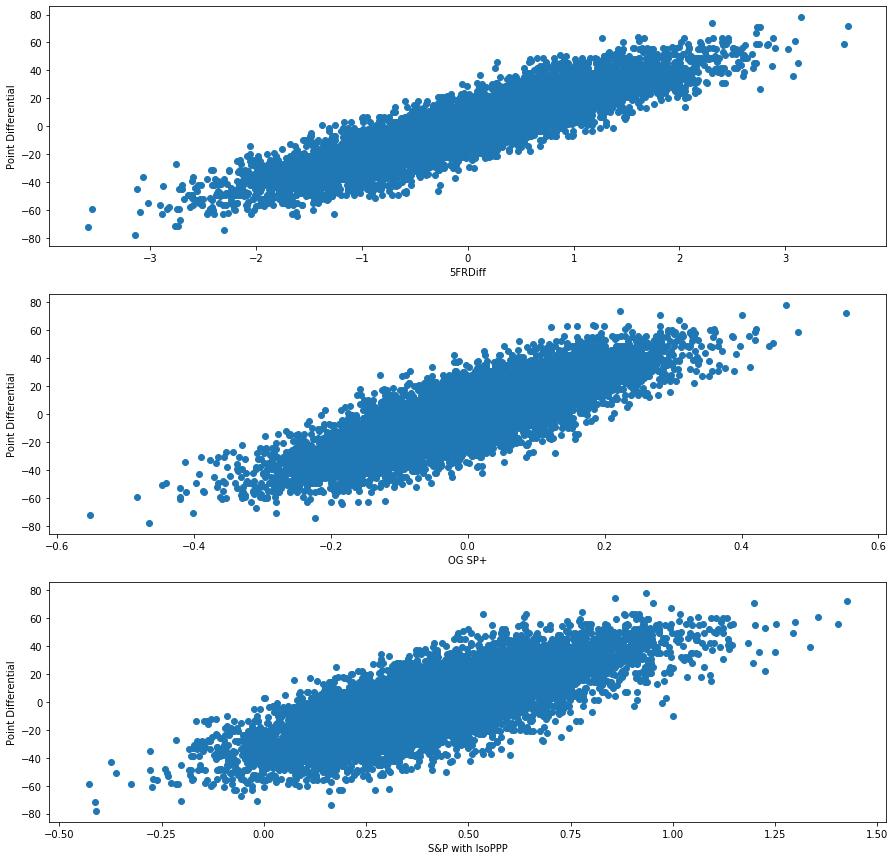

In [14]:
%matplotlib inline
import numpy as np
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
import matplotlib.pyplot as plt
f, axes = plt.subplots(3, figsize=(15, 15))#plt.subplots(len(inputs), figsize=(20, len(inputs) * 8))

# for i in range(len(inputs)):
#     inpt = inputs[i]
axes[0].scatter(stored_game_boxes[f"5FRDiff"], stored_game_boxes.PtsDiff);
axes[0].set_xlabel("5FRDiff")
axes[0].set_ylabel("Point Differential");

axes[1].scatter(0.86*stored_game_boxes[f"OffSRDiff"] + 0.14*stored_game_boxes[f"IsoPPPDiff"], stored_game_boxes.PtsDiff);
axes[1].set_xlabel("OG SP+")
axes[1].set_ylabel("Point Differential");

axes[2].scatter(stored_game_boxes[f"OffSRDiff"] + stored_game_boxes[f"AvgEqPPP"], stored_game_boxes.PtsDiff);
axes[2].set_xlabel("S&P with IsoPPP")
axes[2].set_ylabel("Point Differential");

In [15]:
sp_isoppp = 0.86*stored_game_boxes[f"OffSRDiff"] + 0.14*stored_game_boxes[f"IsoPPPDiff"]
sp_eqppp = stored_game_boxes[f"OffSRDiff"] + stored_game_boxes[f"AvgEqPPP"]
correl = pd.DataFrame(data={"OGS&PDiff":sp_eqppp,"S&PIsoPPPDiff":sp_isoppp,"PtsDiff":stored_game_boxes.PtsDiff})
correl.corr()

,OGS&PDiff,S&PIsoPPPDiff,PtsDiff
OGS&PDiff,1.000000,0.912285,0.757657
S&PIsoPPPDiff,0.912285,1.000000,0.814933
PtsDiff,0.757657,0.814933,1.000000


In [16]:
# Eliminate outliers
from scipy import stats
import numpy as np
stored_game_boxes['5fr_z_score'] = np.abs(stats.zscore(stored_game_boxes['5FRDiff']))
stored_game_boxes['pts_z_score'] = np.abs(stats.zscore(stored_game_boxes.PtsDiff))
stored_game_boxes.head()

,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,ExpTODiff,ActualTODiff,AvgEqPPPDiff,TotalEqPPPDiff,IsoPPPDiff,HavocRateDiff,5FR,5FRDiff,5fr_z_score,pts_z_score
0,UCF,2012,322432006,56.0,42.0,0.796214,0.492537,0.074627,6.029851,0.683285,...,-0.22,0,0.122680,4.387538,0.04152,0.006633,5.436102,0.872203,0.943246,1.899151
1,Akron,2012,322432006,14.0,-42.0,0.203786,0.382716,0.061728,4.370370,0.641765,...,0.22,0,-0.122680,-4.387538,-0.04152,-0.006633,4.563898,-0.872203,0.943246,1.899151
2,South Carolina,2012,322430238,17.0,4.0,0.518995,0.435484,0.080645,5.129032,0.749257,...,0.22,0,0.017305,2.138834,-0.42232,0.042920,5.208914,0.417828,0.451861,0.180871
3,Vanderbilt,2012,322430238,13.0,-4.0,0.481005,0.271186,0.152542,5.813559,1.171577,...,-0.22,0,-0.017305,-2.138834,0.42232,-0.042920,4.791086,-0.417828,0.451861,0.180871
4,Eastern Michigan,2012,322432050,26.0,-11.0,0.020080,0.447761,0.134328,6.119403,1.072704,...,0.00,0,0.087917,-6.578618,0.26167,0.059391,4.731171,-0.537657,0.581451,0.497397


In [17]:
outliers = stored_game_boxes[(stored_game_boxes['5fr_z_score'] >= 3.2) | (stored_game_boxes['pts_z_score'] >= 3)]
basis = stored_game_boxes[(stored_game_boxes['5fr_z_score'] < 3.2) & (stored_game_boxes['pts_z_score'] < 3.)]
msk = (np.random.rand(len(basis)) < 0.80)
train_data = basis[msk]
test_data = basis[~msk]

In [18]:
# outliers

In [19]:
train_data.head()

,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,ExpTODiff,ActualTODiff,AvgEqPPPDiff,TotalEqPPPDiff,IsoPPPDiff,HavocRateDiff,5FR,5FRDiff,5fr_z_score,pts_z_score
0,UCF,2012,322432006,56.0,42.0,0.796214,0.492537,0.074627,6.029851,0.683285,...,-0.22,0,0.122680,4.387538,0.04152,0.006633,5.436102,0.872203,0.943246,1.899151
1,Akron,2012,322432006,14.0,-42.0,0.203786,0.382716,0.061728,4.370370,0.641765,...,0.22,0,-0.122680,-4.387538,-0.04152,-0.006633,4.563898,-0.872203,0.943246,1.899151
2,South Carolina,2012,322430238,17.0,4.0,0.518995,0.435484,0.080645,5.129032,0.749257,...,0.22,0,0.017305,2.138834,-0.42232,0.042920,5.208914,0.417828,0.451861,0.180871
3,Vanderbilt,2012,322430238,13.0,-4.0,0.481005,0.271186,0.152542,5.813559,1.171577,...,-0.22,0,-0.017305,-2.138834,0.42232,-0.042920,4.791086,-0.417828,0.451861,0.180871
4,Eastern Michigan,2012,322432050,26.0,-11.0,0.020080,0.447761,0.134328,6.119403,1.072704,...,0.00,0,0.087917,-6.578618,0.26167,0.059391,4.731171,-0.537657,0.581451,0.497397


In [20]:
# Linear Regression Model
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.utils import check_array
from sklearn.metrics import mean_absolute_error, median_absolute_error, r2_score
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    if (y_true.sum() > 0):
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    else:
        return "???"

inputDiffs = []
for inpt in inputs:
    inputDiffs.append(f"{inpt}Diff")

model = LinearRegression().fit(train_data['5FRDiff'][:, np.newaxis], train_data.PtsDiff)

In [21]:
print(f'Linear Regression: y = {model.coef_[0]:.5f}x + {model.intercept_:.5f}')

preds = model.predict(test_data['5FRDiff'][:, np.newaxis])

print(f"Mean Pred Score: {preds.mean()}")
print(f"Pred Std Dev: {preds.std()}")

# MAPE is not a trustworthy measurement when the mean's going to be near zero
# mape = mean_absolute_percentage_error(test_data["PtsDiff"][:, np.newaxis], preds)
# print(f"MAPE: {mape}%")

MAE = mean_absolute_error(test_data["PtsDiff"][:, np.newaxis], preds)
print(f"Mean Abs Error: {MAE}")

MdnAE = median_absolute_error(test_data["PtsDiff"][:, np.newaxis], preds)
print(f"Mdn Abs Error: {MdnAE}")

corr_matx = {
    'ActPtsDiff' : test_data['PtsDiff'],
}
for inptDf in inputDiffs:
    corr_matx[inptDf] = test_data[inptDf]
corr_matx['5FR'] = test_data['5FR']
corr_matx['5FRDiff'] = test_data['5FRDiff']
corr_matx['PredPtsDiff'] = preds
test = pd.DataFrame(corr_matx)

test.corr()
print(f'R-squared: {r2_score(test_data["PtsDiff"][:,np.newaxis], preds)}\n')
    
test.corr()

Linear Regression: y = 21.29899x + -0.01738
Mean Pred Score: -0.5429848333649314
Pred Std Dev: 19.209312462028564
Mean Abs Error: 7.934916594963587
Mdn Abs Error: 6.544608448136586
R-squared: 0.7856473932981859



,ActPtsDiff,OffSRDiff,OffERDiff,FPDiff,OppRateDiff,OppEffDiff,OppPPDDiff,PPDDiff,OppSRDiff,YPPDiff,ExpTODiff,ActualTODiff,AvgEqPPPDiff,TotalEqPPPDiff,IsoPPPDiff,HavocRateDiff,5FR,5FRDiff,PredPtsDiff
ActPtsDiff,1.000000,0.757664,0.586966,0.472226,0.788716,0.591481,0.593215,0.965806,0.535100,0.782831,-0.448072,-0.417348,0.727158,0.751297,0.238518,0.540199,0.886401,0.886401,0.886401
OffSRDiff,0.757664,1.000000,0.486576,0.251998,0.692088,0.383626,0.424179,0.740186,0.760108,0.713576,-0.285465,-0.134347,0.639282,0.766046,-0.078294,0.558167,0.853186,0.853186,0.853186
OffERDiff,0.586966,0.486576,1.000000,0.154359,0.513641,0.310030,0.314691,0.564231,0.373317,0.809923,-0.210336,-0.122841,0.758656,0.622159,0.557077,0.203563,0.506656,0.506656,0.506656
FPDiff,0.472226,0.251998,0.154359,1.000000,0.591949,0.077157,0.066471,0.435209,0.021801,0.217259,-0.268711,-0.349782,0.208996,0.202510,0.039246,0.229512,0.559426,0.559426,0.559426
OppRateDiff,0.788716,0.692088,0.513641,0.591949,1.000000,0.189384,0.194631,0.777438,0.285799,0.666067,-0.300811,-0.276916,0.594650,0.737820,0.135435,0.505569,0.801451,0.801451,0.801451
OppEffDiff,0.591481,0.383626,0.310030,0.077157,0.189384,1.000000,0.716478,0.566410,0.500224,0.429224,-0.289048,-0.296558,0.398940,0.357894,0.168462,0.285990,0.479431,0.479431,0.479431
OppPPDDiff,0.593215,0.424179,0.314691,0.066471,0.194631,0.716478,1.000000,0.574715,0.569977,0.468192,-0.314154,-0.258402,0.443496,0.361826,0.180953,0.318530,0.534189,0.534189,0.534189
PPDDiff,0.965806,0.740186,0.564231,0.435209,0.777438,0.566410,0.574715,1.000000,0.516346,0.754760,-0.414063,-0.386279,0.701901,0.717819,0.220436,0.532319,0.855788,0.855788,0.855788
OppSRDiff,0.535100,0.760108,0.373317,0.021801,0.285799,0.500224,0.569977,0.516346,1.000000,0.549240,-0.256783,-0.083077,0.500276,0.480056,-0.029510,0.372446,0.622735,0.622735,0.622735
YPPDiff,0.782831,0.713576,0.809923,0.217259,0.666067,0.429224,0.468192,0.754760,0.549240,1.000000,-0.333991,-0.191470,0.918583,0.795471,0.517602,0.448416,0.715914,0.715914,0.715914


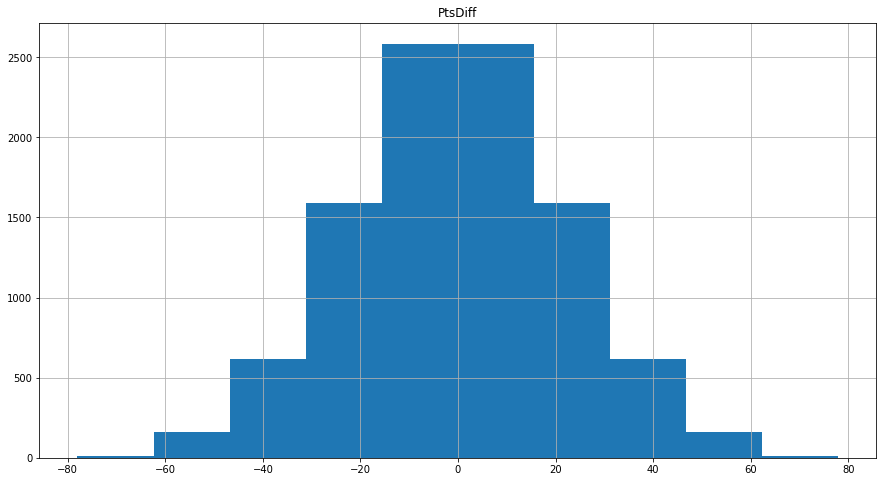

In [22]:
stored_game_boxes.hist(column='PtsDiff', figsize=(15,8));

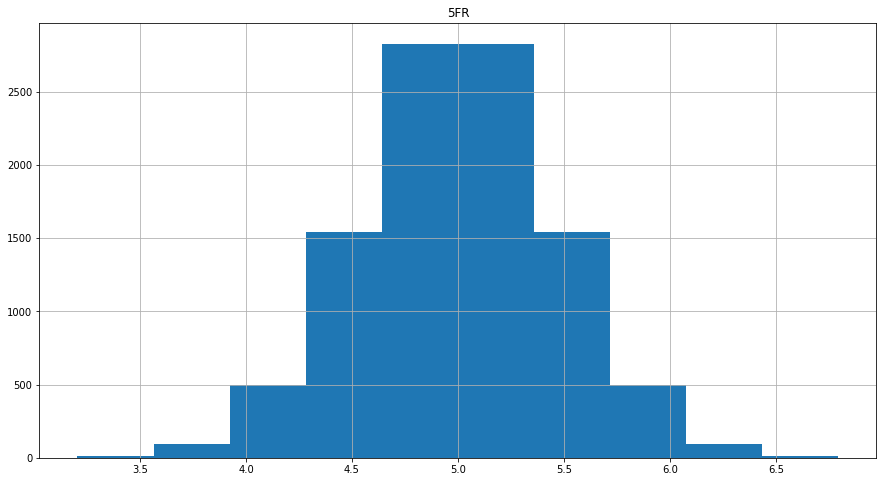

In [23]:
stored_game_boxes.hist(column='5FR', figsize=(15,8));

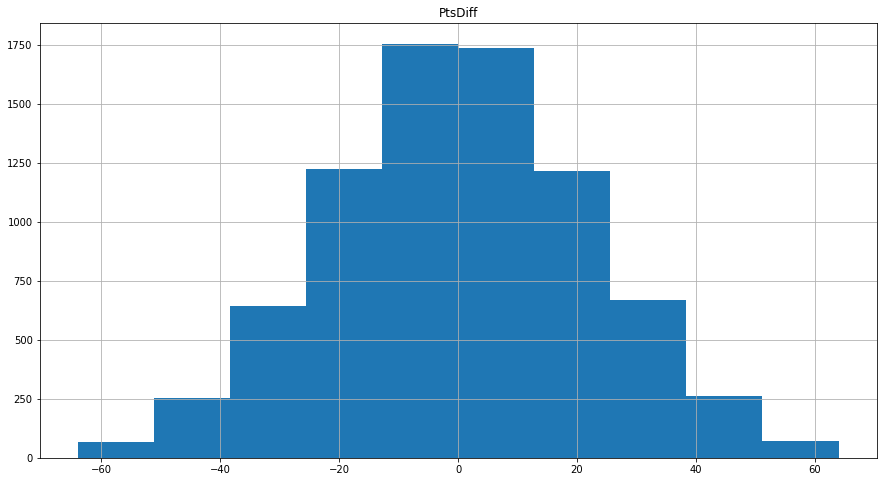

In [24]:
train_data.hist(column='PtsDiff', figsize=(15,8));

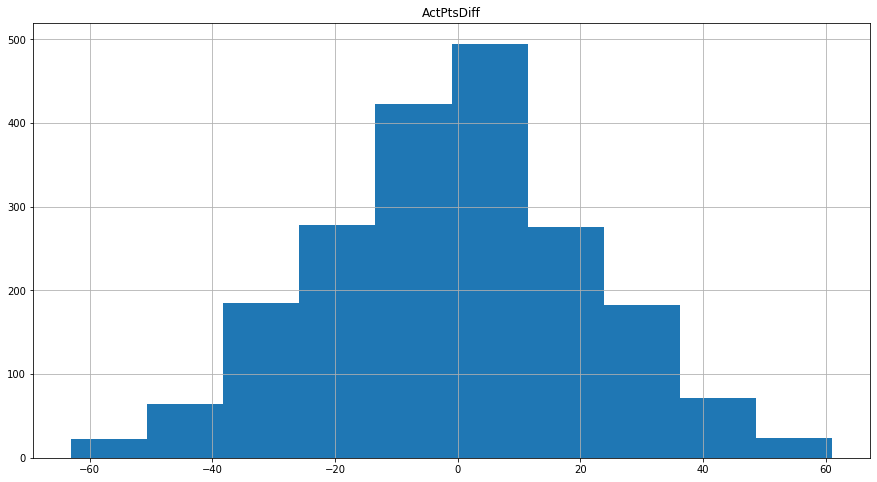

In [25]:
test.hist(column='ActPtsDiff', figsize=(15,8));

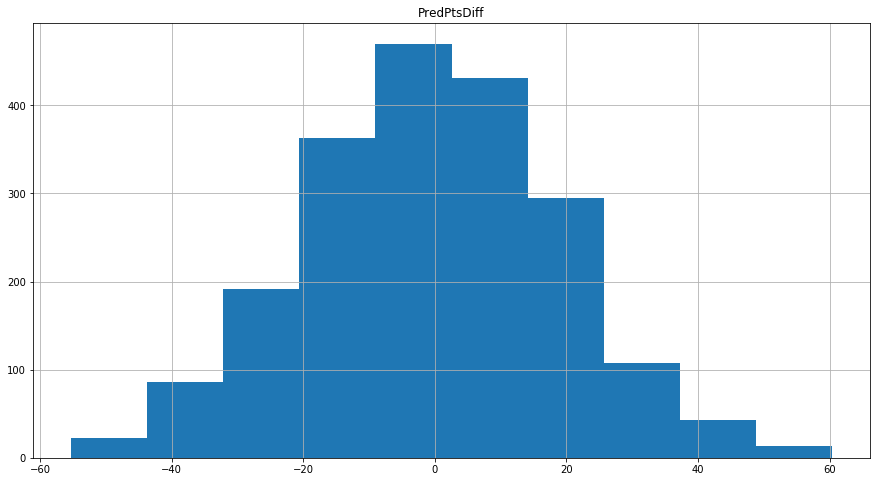

In [26]:
test.hist(column='PredPtsDiff', figsize=(15,8));

In [27]:
def generate_win_prob(game_id, year):
    sample_box = calculate_box_score(game_id, year)
    mu = preds.mean()
    std = preds.std()

    max_box_row = sample_box[sample_box['PtsDiff'] == max(sample_box['PtsDiff'])]
    parts = sample_box.Team.tolist()
    print(f"Game: {parts[0]} @ {parts[1]}")
    print(f"Actual Winner: {stringify_entry(max_box_row.Team)}")
    print(f"MOV: {stringify_entry(max_box_row.Team)} by {stringify_entry(max_box_row.PtsDiff)}")
#     print(f"5FRDiff for {stringify_entry(max_box_row.Team)}: {stringify_entry(max_box_row['5FRDiff'])}")
    proj_point_diff = model.predict(max_box_row['5FRDiff'][:,np.newaxis])[0]
    print(f"Proj MOV: {stringify_entry(max_box_row.Team)} by {round(proj_point_diff)} (exact value: {proj_point_diff})")
    z = (proj_point_diff - mu) / std
    print(f"Z score: {z}")
    print(f"Win Prob for {stringify_entry(max_box_row.Team)}: {(100 * stats.norm.cdf(z)):.2f}%")
    print("---")
    return stats.norm.cdf(z)

In [28]:
generate_win_prob(401013183, 2018)  # 2018 UVA at VT for sample (this should be in the dataset, so not ideal)
calculate_box_score(401013183, 2018)

Game: Virginia @ Virginia Tech
Actual Winner: Virginia Tech
MOV: Virginia Tech by 3.0
Proj MOV: Virginia Tech by -4.0 (exact value: -4.39804224009041)
Z score: -0.20068690195684247
Win Prob for Virginia Tech: 42.05%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,OppSRDiff,YPPDiff,ExpTODiff,ActualTODiff,AvgEqPPPDiff,TotalEqPPPDiff,IsoPPPDiff,HavocRateDiff,5FR,5FRDiff
0,Virginia,2018,401013183,31.0,-3.0,0.875665,0.396825,0.111111,6.507937,0.930578,...,0.118588,0.994779,-0.66,-1,0.103211,2.077885,0.124959,-0.040309,5.102837,0.205675
1,Virginia Tech,2018,401013183,34.0,3.0,0.124335,0.368421,0.078947,5.513158,0.805619,...,-0.118588,-0.994779,0.66,1,-0.103211,-2.077885,-0.124959,0.040309,4.897163,-0.205675


In [29]:
generate_win_prob(401112488, 2019)  # 2019 GT at MIA
calculate_box_score(401112488, 2019)

Game: Georgia Tech @ Miami
Actual Winner: Georgia Tech
MOV: Georgia Tech by 7.0
Proj MOV: Georgia Tech by -16.0 (exact value: -15.759484674911947)
Z score: -0.7921418255664162
Win Prob for Georgia Tech: 21.41%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,OppSRDiff,YPPDiff,ExpTODiff,ActualTODiff,AvgEqPPPDiff,TotalEqPPPDiff,IsoPPPDiff,HavocRateDiff,5FR,5FRDiff
0,Georgia Tech,2019,401112488,28.0,7.0,0.065752,0.396825,0.111111,5.460317,0.894136,...,0.07619,-0.330005,-0.66,1,-0.014422,-0.482035,-0.121075,0.018689,4.630449,-0.739101
1,Miami,2019,401112488,21.0,-7.0,0.934248,0.370968,0.112903,5.790323,1.015211,...,-0.07619,0.330005,0.66,-1,0.014422,0.482035,0.121075,-0.018689,5.369551,0.739101


In [30]:
generate_win_prob(401112513, 2019)  # 2019 NCST at GT
calculate_box_score(401112513, 2019)

Game: NC State @ Georgia Tech
Actual Winner: Georgia Tech
MOV: Georgia Tech by 2.0
Proj MOV: Georgia Tech by -6.0 (exact value: -6.410118881714018)
Z score: -0.30543175659965804
Win Prob for Georgia Tech: 38.00%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,OppSRDiff,YPPDiff,ExpTODiff,ActualTODiff,AvgEqPPPDiff,TotalEqPPPDiff,IsoPPPDiff,HavocRateDiff,5FR,5FRDiff
0,NC State,2019,401112513,26.0,-2.0,0.156447,0.487500,0.150000,5.712500,0.704891,...,-0.01919,-1.322588,0.0,-2,-0.129463,1.273286,-0.300725,0.012719,5.150071,0.300143
1,Georgia Tech,2019,401112513,28.0,2.0,0.843553,0.473684,0.140351,7.035088,1.005617,...,0.01919,1.322588,0.0,2,0.129463,-1.273286,0.300725,-0.012719,4.849929,-0.300143


In [31]:
generate_win_prob(401110863, 2019)  # 2019 Ole Miss at MSST
calculate_box_score(401110863, 2019)

Game: Ole Miss @ Mississippi State
Actual Winner: Mississippi State
MOV: Mississippi State by 1.0
Proj MOV: Mississippi State by 6.0 (exact value: 5.592760541467291)
Z score: 0.3194151475728699
Win Prob for Mississippi State: 62.53%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,OppSRDiff,YPPDiff,ExpTODiff,ActualTODiff,AvgEqPPPDiff,TotalEqPPPDiff,IsoPPPDiff,HavocRateDiff,5FR,5FRDiff
0,Ole Miss,2019,401110863,20.0,-1.0,0.384124,0.422535,0.084507,5.563380,0.880173,...,-0.059649,0.080622,0.22,1,0.020976,6.298842,0.092249,0.000243,4.8683,-0.263399
1,Mississippi State,2019,401110863,21.0,1.0,0.615876,0.413793,0.137931,5.482759,0.787924,...,0.059649,-0.080622,-0.22,-1,-0.020976,-6.298842,-0.092249,-0.000243,5.1317,0.263399


In [32]:
generate_win_prob(401012356, 2018) # 2018 LSU vs TAMU  (this should be in the dataset, so not ideal)
calculate_box_score(401012356, 2018)

Game: LSU @ Texas A&M
Actual Winner: Texas A&M
MOV: Texas A&M by 2.0
Proj MOV: Texas A&M by -8.0 (exact value: -7.975647694736708)
Z score: -0.3869301869113781
Win Prob for Texas A&M: 34.94%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,OppSRDiff,YPPDiff,ExpTODiff,ActualTODiff,AvgEqPPPDiff,TotalEqPPPDiff,IsoPPPDiff,HavocRateDiff,5FR,5FRDiff
0,LSU,2018,401012356,72.0,-2.0,0.321374,0.466667,0.088889,5.511111,0.682602,...,0.014666,0.876496,0.0,-1,-0.103285,-15.374294,-0.349878,0.001282,5.186823,0.373645
1,Texas A&M,2018,401012356,74.0,2.0,0.678626,0.423077,0.105769,4.634615,1.032480,...,-0.014666,-0.876496,0.0,1,0.103285,15.374294,0.349878,-0.001282,4.813177,-0.373645


In [33]:
# Team Ratings by Avg Win Prob??
def calculate_avg_win_prob(team, year):
#     print(team)
    tester = stored_game_boxes[(stored_game_boxes.Team == team) & (stored_game_boxes.Season == year)]
    if (len(tester) == 0):
        return 0
    pred = model.predict([[tester['5FRDiff'].mean()]])
    mu = preds.mean()
    std = preds.std()
    z = (pred[0] - mu) / std
#     print(f"Avg Win Prob for {team}: {(100 * stats.norm.cdf(z)):.2f}%")
    return stats.norm.cdf(z)

consider_teams = teams[teams.conference.isin(fbs)].school.tolist()
team_wp_frame = pd.DataFrame({"team":consider_teams})
team_wp_frame['avg_win_prob'] = team_wp_frame.apply(lambda x: calculate_avg_win_prob(x.team, 2019), axis=1)
# for team in team_list:
#     team_wp_frame = team_wp_frame.append(pd.DataFrame({
#         'team':[team],
#         'avg_win_prob':[calculate_avg_win_prob(team, 2019)]
#     }))
team_wp_frame['games'] = team_wp_frame.apply(lambda x: len(games[(games.season == 2019) & ((games.home_team == x.team) | (games.away_team == x.team))]), axis=1)
team_wp_frame['proj_wins'] = round(team_wp_frame.avg_win_prob * team_wp_frame.games)
team_wp_frame['proj_losses'] = team_wp_frame.games - team_wp_frame['proj_wins']
team_wp_frame = team_wp_frame.sort_values(by=['avg_win_prob','games'], ascending=False)
team_wp_frame.index = range(1,len(team_wp_frame.team)+1)
team_wp_frame

,team,avg_win_prob,games,proj_wins,proj_losses
1,Ohio State,0.942939,13,12.0,1.0
2,Clemson,0.937699,13,12.0,1.0
3,Alabama,0.925895,12,11.0,1.0
4,LSU,0.913980,13,12.0,1.0
5,Wisconsin,0.854275,13,11.0,2.0
...,...,...,...,...,...
126,Bowling Green,0.134751,12,2.0,10.0
127,UMass,0.109412,12,1.0,11.0
128,Akron,0.101138,12,1.0,11.0
129,Rutgers,0.096918,12,1.0,11.0


In [34]:
# Team Ratings by Avg Win Prob??
def calculate_z(item, mu, std):
    return (item - mu) / std

def calculate_second_order_wins(team, year):
#     print(team)
    tester = stored_game_boxes[(stored_game_boxes.Team == team) & (stored_game_boxes.Season == year)]
    if (len(tester) == 0):
        return 0
    pred = model.predict(tester['5FRDiff'][:,np.newaxis])
    mu = preds.mean()
    std = preds.std()
    zs = np.vectorize(calculate_z)(pred, mu, std)
    probs = stats.norm.cdf(zs)
    return probs.sum()

team_second_order_frame = pd.DataFrame({"team":consider_teams})
team_second_order_frame["second_order_wins"] = team_second_order_frame.apply(lambda x: calculate_second_order_wins(x.team, 2019),axis=1)
team_second_order_frame["second_order_losses"] = team_second_order_frame.apply(lambda x: len(games[((games.home_team == x.team) | (games.away_team == x.team)) & (games.season == 2019)]) - x.second_order_wins,axis=1)
team_second_order_frame.sort_values(by=['second_order_wins'], ascending=False)

,team,second_order_wins,second_order_losses
77,Ohio State,11.347652,1.652348
21,Clemson,10.587011,2.412989
53,LSU,10.423193,2.576807
2,Alabama,9.372296,2.627704
128,Wisconsin,9.337857,3.662143
...,...,...,...
25,Connecticut,2.122775,9.877225
1,Akron,2.054766,9.945234
112,UMass,2.040363,9.959637
103,Texas State,2.038011,9.961989


In [117]:
# Matchup Predictor?
grouped_by_year = stored_game_boxes.copy().groupby(['Team','Season'])
ratings = grouped_by_year.apply(lambda x: x['5FR'].mean())
team_fr_year = ratings.reset_index()
team_fr_year.columns = ["Team",'Season','5FR']
team_fr_year

tmp = team_fr_year.groupby('Season').apply(lambda x: x.sort_values(by='5FR', ascending=False)).reset_index(drop=True)
team_strength = pd.DataFrame()
for yr in range(2012, 2020):
    retrieve = tmp[tmp.Season == yr].copy()
    retrieve['Rank'] = range(1, len(retrieve)+1)
    team_strength = team_sos.append(retrieve)
team_strength

,Team,Season,5FR,Rank
0,Alabama,2012,5.606624,1.0
1,Florida State,2012,5.456845,2.0
2,Fresno State,2012,5.371180,3.0
3,Arizona State,2012,5.339381,4.0
4,Oklahoma,2012,5.339329,5.0
...,...,...,...,...
897,Connecticut,2019,4.497653,126.0
898,Bowling Green,2019,4.489725,127.0
899,UMass,2019,4.433154,128.0
900,Akron,2019,4.412666,129.0


In [153]:
# opponents = grouped_by_year.apply(lambda x: x.Team)
# tester = opponents[('Air Force', 2019)]
# tester[tester != 'Air Force']
def filter_opponent(box, team):
    return box[box.Team != team].Team.tolist()[0]

# grouped_by_team = stored_game_boxes.groupby(['GameID'])
opponent_game_ids = pd.DataFrame()
for team in team_list:
    team_games = stored_game_boxes[stored_game_boxes.Team == team].GameID.to_list()
    for item in team_games:
        box = stored_game_boxes[stored_game_boxes.GameID == item]
        opp = filter_opponents(box, team)
        opponent_game_ids = opponent_game_ids.append({'GameID' : item, 'Team':team,'Opponent':opp,'Season':stringify_entry(box.Season)}, ignore_index=True)
opponent_game_ids



,GameID,Opponent,Season,Team
0,322520130.0,Michigan,2012.0,Air Force
1,322662439.0,UNLV,2012.0,Air Force
2,322732005.0,Colorado State,2012.0,Air Force
3,322802005.0,Navy,2012.0,Air Force
4,322872751.0,Wyoming,2012.0,Air Force
...,...,...,...,...
9864,401117533.0,Nevada,2019.0,Wyoming
9865,401117541.0,Boise State,2019.0,Wyoming
9866,401117546.0,Utah State,2019.0,Wyoming
9867,401117550.0,Colorado State,2019.0,Wyoming


In [160]:
def predict_matchup(team1, team2, year):
    team1_avg_ffr = grouped_by_year.get_group((team1, year))['5FR'][-4:].mean()#stored_game_boxes[(stored_game_boxes.Team == team1) & (stored_game_boxes.Season == year)]['5FR'][-4:].mean()
    team2_avg_ffr = grouped_by_year.get_group((team2, year))['5FR'][-4:].mean()#stored_game_boxes[(stored_game_boxes.Team == team2) & (stored_game_boxes.Season == year)]['5FR'][-4:].mean()
    
    # adjust based on strength of schedule
    team1_opps = opponent_game_ids[opponent_game_ids.Team == team1].Opponent.to_list()
    team2_opps = opponent_game_ids[opponent_game_ids.Team == team2].Opponent.to_list()
    team1_sos = team_strength[(team_strength.Team.isin(team1_opps)) & (team_strength.Season == year)]['5FR'].mean()
    team2_sos = team_strength[(team_strength.Team.isin(team2_opps)) & (team_strength.Season == year)]['5FR'].mean()
    team1_avg_ffr *= (team1_sos / team2_sos)
    
    ffr_diff = team1_avg_ffr - team2_avg_ffr # assumes team_1 is home
    pred = model.predict([[ffr_diff]])
    mu = preds.mean()
    std = preds.std()
    z = (pred[0] - mu) / std
    win_prob = stats.norm.cdf(z)
    return [win_prob, pred[0]]

predict_matchup('Georgia Tech','Clemson',2019)

[0.035807764352039195, -35.14960773419628]

In [158]:
team_triples = [
    ['LSU','Oklahoma',11], # CFP Semifinal: Peach Bowl
    ['Clemson','Ohio State',2.5], # CFP Semifinal: Fiesta Bowl
    ['Penn State','Memphis',7], # Cotton Bowl
    ['Florida','Virginia',14], # Orange Bowl
    ['Wisconsin','Oregon',2.5], # Rose Bowl
    ['Georgia','Baylor',7.5], # Sugar Bowl
    ['UCF','Marshall',15],
    ['BYU',"Hawai'i",2],
    ['Miami','Louisiana Tech',6],
    ['Pittsburgh','Eastern Michigan',11],
    ['North Carolina','Temple',5],
    ['Michigan State','Wake Forest',3.5],
    ['Texas A&M', 'Oklahoma State', 7],
    ['Iowa', 'USC', 2.5],
    ['Air Force', 'Washington State', 3],
    ['Texas A&M', 'Oklahoma State', 7],
    ['Notre Dame', 'Iowa State', 4],
    ['Western Kentucky', 'Western Michigan', 3.5],
    ['Mississippi State', 'Louisville', 4],
    ['California', 'Illinois', 6.5],
    ['Virginia Tech', 'Kentucky', 3],
    ['Arizona State', 'Florida State', 4],
    ['Navy', 'Kansas State', 2],
    ['Wyoming', 'Georgia State', 7],
    ['Utah', 'Texas', 7],
    ['Auburn', 'Minnesota', 7.5],
    ['Alabama', 'Michigan', 7],
    ['Cincinnati', 'Boston College',7],
    ['Tennessee', 'Indiana', 1.5],
    ['Ohio', 'Nevada', 7.5],
    ['Tulane', 'Southern Mississippi', 7],
    ['Louisiana', 'Miami (OH)', 14]
]

bets = pd.DataFrame()

for data in team_triples:
    team1 = data[0]
    team2 = data[1]
    spread = data[2] # team 1 is always favorite
    predictor = predict_matchup(team1, team2, 2019)
    bets = bets.append(pd.DataFrame({
        "favorite": [team1],
        "opponent" : [team2],
        "spread" : [spread],
        "proj_MOV" : [predictor[1]],
        "proj_win_prob" : [predictor[0]],
        "proj_cover_status" : [predictor[1] > spread],
        "ml_pick": [team1 if (predictor[1] > 0) else team2],
        "ats_pick": [team1 if (predictor[1] > spread) else team2]
    }))
    
bets.sort_values(by=['proj_cover_status','proj_MOV'], ascending=False)

,favorite,opponent,spread,proj_MOV,proj_win_prob,proj_cover_status,ml_pick,ats_pick
0,Clemson,Ohio State,2.5,11.850499,0.740595,True,Clemson,Clemson
0,Notre Dame,Iowa State,4.0,10.795223,0.722487,True,Notre Dame,Notre Dame
0,Michigan State,Wake Forest,3.5,10.686945,0.720595,True,Michigan State,Michigan State
0,Navy,Kansas State,2.0,8.761993,0.685949,True,Navy,Navy
0,Air Force,Washington State,3.0,7.818322,0.668318,True,Air Force,Air Force
0,Miami,Louisiana Tech,6.0,6.188734,0.636996,True,Miami,Miami
0,Western Kentucky,Western Michigan,3.5,4.540284,0.604351,True,Western Kentucky,Western Kentucky
0,Virginia Tech,Kentucky,3.0,4.325575,0.600039,True,Virginia Tech,Virginia Tech
0,BYU,Hawai'i,2.0,2.508581,0.563110,True,BYU,BYU
0,LSU,Oklahoma,11.0,8.966727,0.689720,False,LSU,Oklahoma


In [ ]:
generate_win_prob(401112521, 2019)  # 2019 VT @ UVA
calculate_box_score(401112521, 2019)

In [ ]:
generate_win_prob(401112475, 2019) # 2019 UNC at GT
calculate_box_score(401112475, 2019)

In [ ]:
generate_win_prob(401112498, 2019) # 2019 Pitt at GT
calculate_box_score(401112498, 2019)

In [ ]:
generate_win_prob(401110865, 2019) # 2019 Iron Bowl
calculate_box_score(401110865, 2019)

In [ ]:
generate_win_prob(401110867, 2019)
calculate_box_score(401110867, 2019)

In [ ]:
def filter_opponent(box, team):
    return box[box.Team != team].Team.tolist()[0]

def filter_MOV(box, team):
    return box[box.Team == team].PtsDiff.tolist()[0]

def clean_win_prob(row):
    prob = generate_win_prob(row.GameID, 2019)
    return prob if row.ActualMOV > 0 else 1-prob

def retrieve_win_probs(team, year):
    game_ids = games[((games.home_team == team) | (games.away_team == team)) & (games.season == year)].id
    frame = pd.DataFrame({"GameID":game_ids,"Year":year})
    frame['Team'] = team
    frame['Opponent'] = frame.apply(lambda y: filter_opponent(calculate_box_score(y.GameID, 2019),team), axis=1)
    frame['ActualMOV'] = frame.apply(lambda y: filter_MOV(calculate_box_score(y.GameID, 2019),team), axis=1)
    frame['PostGameWinProb'] = frame.apply(lambda x: clean_win_prob(x) * 100, axis=1)
    return frame

retrieve_win_probs("Georgia Tech", 2019)

In [ ]:
# import pickle
# from datetime import datetime
# now = datetime.now()
# filename = now.strftime("%d-%b-%Y-%H:%M:%S")
# pkl_filename = f"results/wp_model-{filename}.pkl"
# with open(pkl_filename, 'wb') as file:
#     pickle.dump(model, file)